In [1]:
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
print('Landsat on Google:')
filepath = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'
with rasterio.open(filepath) as src:
    print(src.profile)

Landsat on Google:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7821, 'height': 7951, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [3]:
print('Landsat on AWS:')
filepath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'
with rasterio.open(filepath) as src:
    print(src.profile)

Landsat on AWS:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7821, 'height': 7951, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


oviews: [3, 9, 27, 81]
Decimation factor= 81
array type:  <class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Text(0, 0.5, 'Row #')

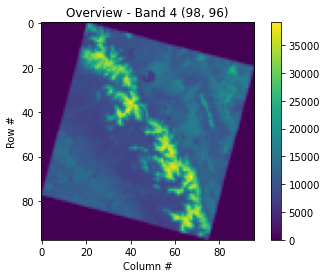

In [9]:
# The grid of raster values can be accessed as a numpy array and plotted:
with rasterio.open(filepath) as src:
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[-1] # let's look at the smallest thumbnail
    print("oviews:",oviews)
    print('Decimation factor= {}'.format(oview))
    # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

print('array type: ',type(thumbnail))
print(thumbnail)

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

Decimation factor= 81


Text(0, 0.5, 'Row #')

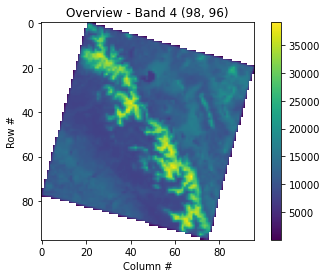

In [17]:
with rasterio.open(filepath) as src:
    oviews = src.overviews(1)
    oview = oviews[-1]
    print('Decimation factor= {}'.format(oview))
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

    thumbnail = thumbnail.astype('f4')
    thumbnail[thumbnail==0] = np.nan

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

Text(0, 0.5, 'Row #')

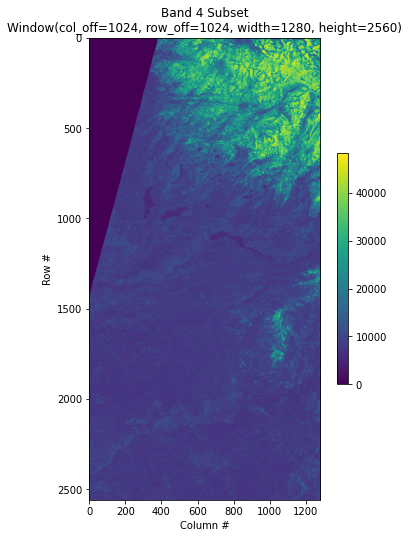

In [18]:
#https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
#rasterio.windows.Window(col_off, row_off, width, height)
window = rasterio.windows.Window(1024, 1024, 1280, 2560)

with rasterio.open(filepath) as src:
    subset = src.read(1, window=window)

plt.figure(figsize=(6,8.5))
plt.imshow(subset)
plt.colorbar(shrink=0.5)
plt.title(f'Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

Decimation factor= 9


Text(0, 0.5, 'Row #')

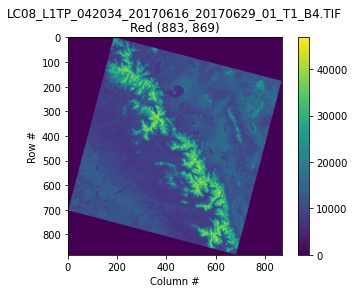

In [13]:
# Use the same example image:
date = '2017-06-16'
url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/'
redband = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(4)
nirband = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(5)

with rasterio.open(url+redband) as src:
    profile = src.profile
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    red = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

plt.imshow(red)
plt.colorbar()
plt.title('{}\nRed {}'.format(redband, red.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

Text(0, 0.5, 'Row #')

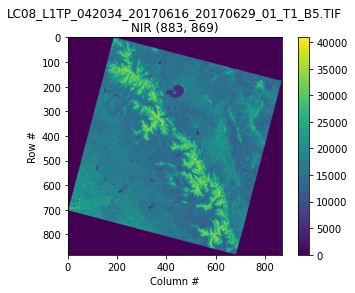

In [14]:
with rasterio.open(url+nirband) as src:
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    nir = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

plt.imshow(nir)
plt.colorbar()
plt.title('{}\nNIR {}'.format(nirband, nir.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

/Users/purgatorid/.local/share/virtualenvs/tiff-explore-TwY5KnPB/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0, 0.5, 'Row #')

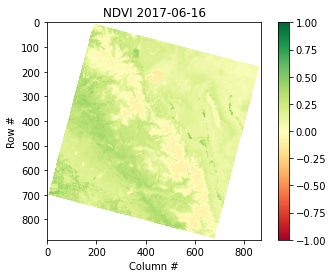

In [15]:
def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi

ndvi = calc_ndvi(nir,red)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

In [16]:
localname = 'LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW.tif'

with rasterio.open(url+nirband) as src:
    profile = src.profile.copy()

    aff = src.transform
    newaff = rasterio.Affine(aff.a * oview, aff.b, aff.c,
                             aff.d, aff.e * oview, aff.f)
    profile.update({
            'dtype': 'float32',
            'height': ndvi.shape[0],
            'width': ndvi.shape[1],
            'transform': newaff})  

    with rasterio.open(localname, 'w', **profile) as dst:
        dst.write_band(1, ndvi)

In [1]:
# Reopen the file and plot
with rasterio.open(localname) as src:
    print(src.profile)
    ndvi = src.read(1) # read the entire array

plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

NameError: name 'rasterio' is not defined

In [24]:
with rasterio.open(localname) as src:
    # Use pyproj to convert point coordinates
    utm = pyproj.Proj(src.crs) # Pass CRS of image from rasterio
    lonlat = pyproj.Proj(init='epsg:4326')

    lon,lat = (-119.770163586, 36.741997032)
    east,north = pyproj.transform(lonlat, utm, lon, lat)

    print('Fresno NDVI\n-------')
    print(f'lon,lat=\t\t({lon:.2f},{lat:.2f})')
    print(f'easting,northing=\t({east:g},{north:g})')

    # What is the corresponding row and column in our image?
    row, col = src.index(east, north) # spatial --> image coordinates
    print(f'row,col=\t\t({row},{col})')

    # What is the NDVI?
    value = ndvi[row, col]
    print(f'ndvi=\t\t\t{value:.2f}')


    # Or if you see an interesting feature and want to know the spatial coordinates:
    row, col = 200, 450
    east, north = src.xy(row,col) # image --> spatial coordinates
    lon,lat = pyproj.transform(utm, lonlat, east, north)
    value = ndvi[row, col]
    print(f'''
Interesting Feature
-------
row,col=          ({row},{col})
easting,northing= ({east:g},{north:g})
lon,lat=          ({lon:.2f},{lat:.2f})
ndvi=              {value:.2f}
''')

Fresno NDVI
-------
lon,lat=		(-119.77,36.74)
easting,northing=	(252664,4.06983e+06)
row,col=		(734,179)
ndvi=			0.24

Interesting Feature
-------
row,col=          (200,450)
easting,northing= (325920,4.21398e+06)
lon,lat=          (-118.98,38.06)
ndvi=              -0.10



/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: This function is deprecated. See: h

In [25]:
# Use the same example image:
date2 = '2018-06-19'
url2 = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20180619_20180703_01_T1/'
redband2 = 'LC08_L1TP_042034_20180619_20180703_01_T1_B{}.TIF'.format(4)
nirband2 = 'LC08_L1TP_042034_20180619_20180703_01_T1_B{}.TIF'.format(5)

filepath = url2+redband2
with rasterio.open(filepath) as src:
    print('Opening:', filepath)
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    red2 = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

filepath = url2+nirband2
with rasterio.open(filepath) as src:
    print('Opening:', filepath)
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    nir2 = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

ndvi2 = calc_ndvi(nir2, red2)

Opening: http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20180619_20180703_01_T1/LC08_L1TP_042034_20180619_20180703_01_T1_B4.TIF
Decimation factor= 9
Opening: http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20180619_20180703_01_T1/LC08_L1TP_042034_20180619_20180703_01_T1_B5.TIF
Decimation factor= 9


/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0.5, 1.0, 'Diff (2018-06-19 - 2017-06-16)')

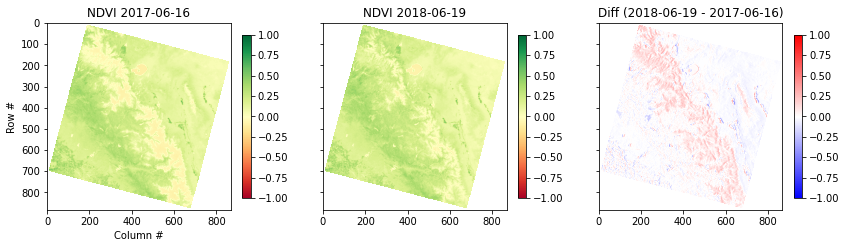

In [26]:
fig, axes = plt.subplots(1,3, figsize=(14,6), sharex=True, sharey=True)

plt.sca(axes[0])
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(shrink=0.5)
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

plt.sca(axes[1])
plt.imshow(ndvi2, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(shrink=0.5)
plt.title('NDVI {}'.format(date2))

plt.sca(axes[2])
plt.imshow(ndvi2 - ndvi, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(shrink=0.5)
plt.title('Diff ({} - {})'.format(date2, date))

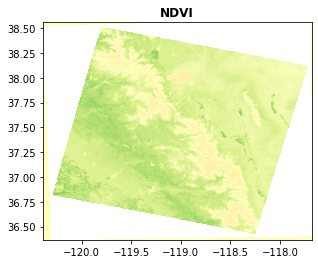

In [27]:
import rasterio.warp
import rasterio.shutil

localname = 'LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW.tif'
vrtname = 'LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW_WGS84.vrt'

with rasterio.open(localname) as src:
    with rasterio.vrt.WarpedVRT(src, crs='epsg:4326', resampling=rasterio.enums.Resampling.bilinear) as vrt:
        rasterio.shutil.copy(vrt, vrtname, driver='VRT')

# Open the local warped file and plot
# NOTE our coordinates have changed to lat, lon. we should probably crop the edge artifacts do to reprojection too!
with rasterio.open(vrtname) as src:
    rasterio.plot.show(src, title='NDVI', cmap='RdYlGn', vmin=-1, vmax=1)

In [28]:
localname = 'LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW.tif'
tifname = 'LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW_WGS84.tif'

dst_crs = 'EPSG:4326'

with rasterio.open(localname) as src:
    profile = src.profile.copy()

    transform, width, height = rasterio.warp.calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)

    profile.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(tifname, 'w', **profile) as dst:
        rasterio.warp.reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=rasterio.warp.Resampling.bilinear)